# Introduction to DataFrames
**[Bogumił Kamiński](http://bogumilkaminski.pl/about/), July 16, 2019**

In [1]:
using DataFrames

## Extras - selected functionalities of selected packages

In [2]:
using FreqTables
df = DataFrame(a=rand('a':'d', 1000), b=rand(["x", "y", "z"], 1000))
ft = freqtable(df, :a, :b) # observe that dimensions are sorted if possible

4×3 Named Array{Int64,2}
a ╲ b │   x    y    z
──────┼──────────────
'a'   │  91   78   94
'b'   │  73   92   87
'c'   │  78  102   85
'd'   │  71   76   73

In [3]:
ft[1,1], ft['b', "z"] # you can index the result using numbers or names

(91, 87)

In [4]:
prop(ft, 1) # getting proportions - 1 means we want to calculate them in rows (first dimension)

4×3 Named Array{Float64,2}
a ╲ b │        x         y         z
──────┼─────────────────────────────
'a'   │ 0.346008  0.296578  0.357414
'b'   │ 0.289683  0.365079  0.345238
'c'   │  0.29434  0.384906  0.320755
'd'   │ 0.322727  0.345455  0.331818

In [5]:
prop(ft, 2) # and columns are normalized to 1.0 now

4×3 Named Array{Float64,2}
a ╲ b │        x         y         z
──────┼─────────────────────────────
'a'   │ 0.290735  0.224138  0.277286
'b'   │ 0.233227  0.264368  0.256637
'c'   │ 0.249201  0.293103  0.250737
'd'   │ 0.226837  0.218391  0.215339

In [6]:
x = categorical(rand(1:3, 10))
levels!(x, [3, 1, 2, 4]) # reordering levels and adding an extra level
freqtable(x) # order is preserved and not-used level is shown

4-element Named Array{Int64,1}
Dim1  │ 
──────┼──
3     │ 1
1     │ 2
2     │ 7
4     │ 0

In [7]:
freqtable([1,1,2,3,missing]) # by default missings are listed

4-element Named Array{Int64,1}
Dim1    │ 
────────┼──
1       │ 2
2       │ 1
3       │ 1
missing │ 1

In [8]:
freqtable([1,1,2,3,missing], skipmissing=true) # but we can skip them

3-element Named Array{Int64,1}
Dim1  │ 
──────┼──
1     │ 2
2     │ 1
3     │ 1

In [9]:
df = DataFrame(a=rand(3:4, 1000), b=rand(5:6, 1000))
ft = freqtable(df, :a, :b) # now dimensions are numbers

2×2 Named Array{Int64,2}
a ╲ b │   5    6
──────┼─────────
3     │ 233  238
4     │ 276  253

In [10]:
ft[3,5] # this is an error - standard array indexing takes precedence

BoundsError: BoundsError: attempt to access 2×2 Array{Int64,2} at index [3, 5]

In [11]:
using NamedArrays
ft[Name(3), Name(5)] # you have to use Name() from NamedArrays

233

### DataFramesMeta - working on `DataFrame`

In [12]:
using DataFramesMeta
df = DataFrame(x=1:8, y='a':'h', z=repeat([true,false], outer=4))

,x,y,z
,Int64,Char,Bool
1,1,'a',true
2,2,'b',false
3,3,'c',true
4,4,'d',false
5,5,'e',true
6,6,'f',false
7,7,'g',true
8,8,'h',false


In [13]:
@with(df, :x+:z) # expressions with columns of DataFrame

8-element Array{Int64,1}:
 2
 2
 4
 4
 6
 6
 8
 8

In [14]:
@with df begin # you can define code blocks
    a = :x[:z]
    b = :x[.!:z]
    :y + [a; b]
end

8-element Array{Char,1}:
 'b'
 'e'
 'h'
 'k'
 'g'
 'j'
 'm'
 'p'

In [15]:
a # @with creates hard scope so variables do not leak out

UndefVarError: UndefVarError: a not defined

In [16]:
df2 = DataFrame(a = [:a, :b, :c])
@with(df2, :a .== ^(:a)) # sometimes we want to work on a raw Symbol, ^() escapes it

3-element BitArray{1}:
  true
 false
 false

In [17]:
df2 = DataFrame(x=1:3, y=4:6, z=7:9)
@with(df2, cols(2:3)) # cols(expression) selects given columns

,y,z
,Int64,Int64
1,4,7
2,5,8
3,6,9


In [18]:
@where(df, :x .< 4, :z .== true) # a very useful macro for filtering

,x,y,z
,Int64,Char,Bool
1,1,'a',true
2,3,'c',true


In [19]:
@select(df, :x, y = 2*:x, z=:y) # create a new DataFrame based on the old one

,x,y,z
,Int64,Int64,Char
1,1,2,'a'
2,2,4,'b'
3,3,6,'c'
4,4,8,'d'
5,5,10,'e'
6,6,12,'f'
7,7,14,'g'
8,8,16,'h'


In [20]:
@transform(df, x = 2*:x, y=:x) # create a new DataFrame adding columns based on the old one

,x,y,z
,Int64,Int64,Bool
1,2,1,true
2,4,2,false
3,6,3,true
4,8,4,false
5,10,5,true
6,12,6,false
7,14,7,true
8,16,8,false


In [21]:
@orderby(df, :z, -:x) # sorting into a new data frame, less powerful than sort, but lightweight

,x,y,z
,Int64,Char,Bool
1,8,'h',false
2,6,'f',false
3,4,'d',false
4,2,'b',false
5,7,'g',true
6,5,'e',true
7,3,'c',true
8,1,'a',true


In [22]:
@linq df |> # chaining of operations on DataFrame
    where(:x .< 5) |>
    orderby(:z) |>
    transform(x²=:x.^2) |>
    select(:z, :x, :x²)

,z,x,x²
,Bool,Int64,Int64
1,false,2,4
2,false,4,16
3,true,1,1
4,true,3,9


### DataFramesMeta - working on grouped `DataFrame`

In [23]:
df = DataFrame(a = 1:12, b = repeat('a':'d', outer=3))
g = groupby(df, :b)

,a,b
,Int64,Char
1,1,'a'
2,5,'a'
3,9,'a'
,a,b
,Int64,Char
1,4,'d'
2,8,'d'
3,12,'d'


In [24]:
using Statistics
@by(df, :b, first=first(:a), last=last(:a), mean=mean(:a)) # similar to DataFrames

,b,first,last,mean
,Char,Int64,Int64,Float64
1,'a',1,9,5.0
2,'b',2,10,6.0
3,'c',3,11,7.0
4,'d',4,12,8.0


In [25]:
@based_on(g, first=first(:a), last=last(:a), mean=mean(:a)) # the same as by but on grouped DataFrame

,b,first,last,mean
,Char,Int64,Int64,Float64
1,'a',1,9,5.0
2,'b',2,10,6.0
3,'c',3,11,7.0
4,'d',4,12,8.0


In [26]:
@where(g, mean(:a) > 6.5) # filter gropus on aggregate conditions

,a,b
,Int64,Char
1,3,'c'
2,7,'c'
3,11,'c'
,a,b
,Int64,Char
1,4,'d'
2,8,'d'
3,12,'d'


In [27]:
@orderby(g, -sum(:a)) # order groups on aggregate conditions

,a,b
,Int64,Char
1,4,'d'
2,8,'d'
3,12,'d'
,a,b
,Int64,Char
1,1,'a'
2,5,'a'
3,9,'a'


In [28]:
@transform(g, center = mean(:a), centered = :a .- mean(:a)) # perform operations within a group and return ungroped DataFrame

,a,b,center,centered
,Int64,Char,Float64,Float64
1,1,'a',5.0,-4.0
2,5,'a',5.0,0.0
3,9,'a',5.0,4.0
4,2,'b',6.0,-4.0
5,6,'b',6.0,0.0
6,10,'b',6.0,4.0
7,3,'c',7.0,-4.0
8,7,'c',7.0,0.0
9,11,'c',7.0,4.0


In [29]:
DataFrame(g) # convinience equivalent to collect(g)

,a,b
,Int64,Char
1,1,'a'
2,5,'a'
3,9,'a'
4,2,'b'
5,6,'b'
6,10,'b'
7,3,'c'
8,7,'c'
9,11,'c'


In [30]:
@transform(g) # actually this is the same as DataFrame()

,a,b
,Int64,Char
1,1,'a'
2,5,'a'
3,9,'a'
4,2,'b'
5,6,'b'
6,10,'b'
7,3,'c'
8,7,'c'
9,11,'c'


In [31]:
@linq df |> groupby(:b) |> where(mean(:a) > 6.5) |> DataFrame # you can do chaining on grouped DataFrames as well

,a,b
,Int64,Char
1,3,'c'
2,7,'c'
3,11,'c'
4,4,'d'
5,8,'d'
6,12,'d'


### DataFramesMeta - rowwise operations on `DataFrame`

In [32]:
df = DataFrame(a = 1:12, b = repeat(1:4, outer=3))

,a,b
,Int64,Int64
1,1,1
2,2,2
3,3,3
4,4,4
5,5,1
6,6,2
7,7,3
8,8,4
9,9,1


In [33]:
# such conditions are often needed but are complex to write
@transform(df, x = ifelse.((:a .> 6) .& (:b .== 4), "yes", "no"))

,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


In [34]:
# one option is to use a function that works on a single observation and broadcast it
myfun(a, b) = a > 6 && b == 4 ? "yes" : "no"
@transform(df, x = myfun.(:a, :b))

,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


In [35]:
# or you can use @byrow! macro that allows you to process DataFrame rowwise
@byrow! df begin
    @newcol x::Vector{String}
    :x = :a > 6 && :b == 4 ? "yes" : "no"
end

,a,b,x
,Int64,Int64,String
1,1,1,no
2,2,2,no
3,3,3,no
4,4,4,no
5,5,1,no
6,6,2,no
7,7,3,no
8,8,4,yes
9,9,1,no


### Visualizing data with StatsPlots

In [36]:
using StatsPlots # you might need to setup Plots package and some plotting backend first
default(fmt=:png)

In [37]:
# we present only a minimal functionality of the package

In [38]:
using Random
Random.seed!(1)
df = DataFrame(x = sort(randn(1000)), y=randn(1000), z = [fill("b", 500); fill("a", 500)]);

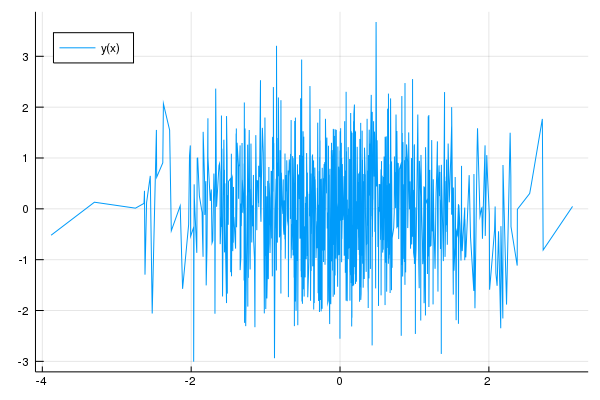

In [39]:
@df df plot(:x, :y, legend=:topleft, label="y(x)") # a most basic plot

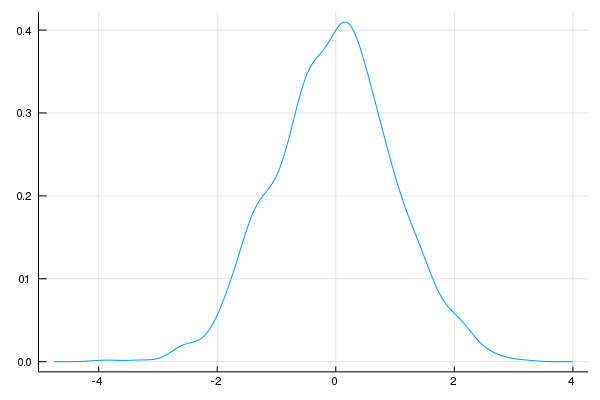

In [40]:
@df df density(:x, label="") # density plot

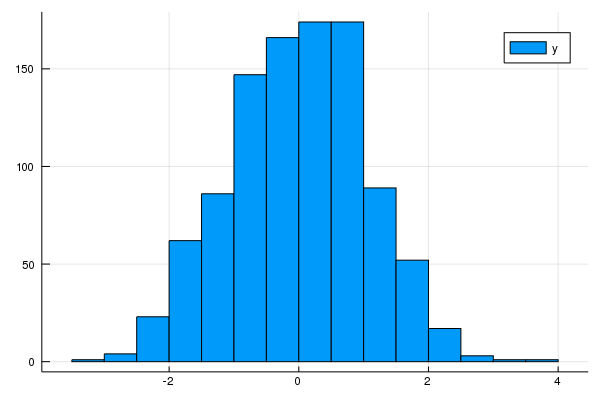

In [41]:
@df df histogram(:y, label="y") # and a histogram

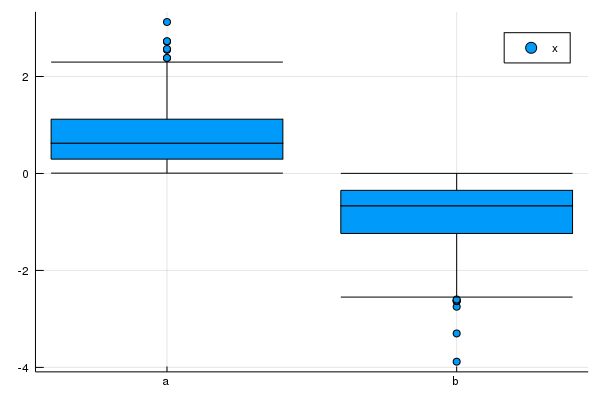

In [42]:
@df df boxplot(:z, :x, label="x")

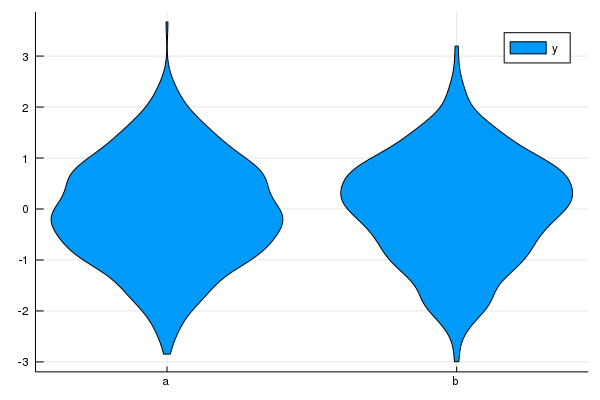

In [43]:
@df df violin(:z, :y, label="y") 